In [1]:
import pandas as pd
import numpy as np


In [3]:
# load data
url = "https://raw.githubusercontent.com/nikhil-bhargava/ids-705-final-project/main/data/raw/worldcities.csv"
city = pd.read_csv(url)
df = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/raw/train.csv')

In [4]:
# select relevant cities
city_df = city[city['id'].astype('str').isin(['1840034016', '1840020491', '1840000494', 
                                '1840006060', '1840000455', '1840021543'])]
city_df = city_df.rename(columns={'id':'city_id', 'city':'city_name'})
city_df['city_id'] = city_df['city_id'].astype('str')

In [5]:
bnb_city_id = {'NYC':'1840034016', 'SF':'1840021543', 'DC':'1840006060', 'LA':'1840020491', 'Chicago':'1840000494', 
               'Boston':'1840000455'}

df['city_id'] = df['city'].map(bnb_city_id)

In [6]:
#city_df= city_df[['city_id', 'lat', 'lng']]

In [7]:
new_df = pd.merge(df, city_df, how='left', on='city_id')

In [8]:
new_df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,city_name,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,San Francisco,San Francisco,37.7562,-122.4430,United States,US,USA,California,NaN,3592294.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,Washington,Washington,38.9047,-77.0163,United States,US,USA,District of Columbia,primary,5379184.0


In [9]:
new_df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,city_name,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18713220.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,San Francisco,San Francisco,37.7562,-122.4430,United States,US,USA,California,NaN,3592294.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,Washington,Washington,38.9047,-77.0163,United States,US,USA,District of Columbia,primary,5379184.0


In [10]:
new_df.drop('iso3', axis=1, inplace=True)

In [11]:
new_df.drop('iso2', axis=1, inplace=True)

In [12]:
new_df.drop('city_ascii', axis=1, inplace=True)

## Feature Engineering

#### Distance of Airbnb to city center


In [13]:
from geopy import distance

def dist_city_center(prop_lat, prop_lon, city_lat, city_lon):
    prop_coords = (prop_lat, prop_lon)
    city_coords = (city_lat, city_lon)
    dist = distance.great_circle(prop_coords, city_coords).miles
    return dist


In [14]:
new_df['cc_dist'] = new_df.apply(lambda x: dist_city_center(x.latitude, x.longitude, x.lat, x.lng), axis=1)


In [15]:

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
#     m = km * 0.621371
    
    return km


In [16]:
def num_close_airbnbs(y, df, dist_thresh):
    df['cur_lat'] = y.latitude
    df['cur_lon'] = y.longitude
    df['rel_dist'] = haversine_np(df['cur_lon'], df['cur_lat'], df['longitude'], df['latitude'])
    num_close = df[df['rel_dist']<=dist_thresh]
    return len(num_close)-1

In [17]:
# takes ~10 mins to run
df = new_df.copy()
new_df['num_bnb_1km'] = new_df.apply(lambda y: num_close_airbnbs(y, df, 1), axis=1)

#### Description Length

In [18]:
new_df['desc_len'] = new_df['description'].str.len()
new_df['name_len'] = new_df['name'].str.len()

#### Ratio of Bedrooms to bathrooms

In [19]:
new_df['bed_bath_ratio'] = round(new_df.bedrooms/new_df.bathrooms,2)

#### How long has the host been hosting

In [20]:
new_df['today'] = '2021-04-01'

In [21]:
new_df['host_since'] = pd.to_datetime(new_df['host_since'])
new_df['today'] = pd.to_datetime(new_df['today'])
new_df['years_of_hosting'] = round(((new_df['today'] - new_df['host_since']).dt.days)/365,1)

#### Years since last review (benchmark date = 2021-04-01)

In [22]:
new_df['last_review'] = pd.to_datetime(new_df['last_review'])
new_df['years_since_lastreview'] = round(((new_df['today'] - new_df['last_review']).dt.days)/365,1)

In [23]:
# Dropping the column I made to get the dates
new_df.drop('today', axis=1, inplace=True)

In [25]:
# null values generated because there is no 'last_review'
new_df.years_since_lastreview.isnull().sum()

15827

#### Change % to float for column 'host_response_rate'

In [26]:
new_df['host_response_rate'] = new_df['host_response_rate'].str.rstrip('%').astype('float')


In [27]:
new_df.shape

(74111, 44)

#### Column 'host_has_profile_pic', 'host_since', 'host_identity_verified' all has 203 missing values

In [28]:
# Let's change all nan values to 'f' (no profile pic, identity not verified)
new_df.loc[new_df['host_has_profile_pic'].isnull(), 'host_has_profile_pic'] = 'f'
new_df.loc[new_df['host_identity_verified'].isnull(), 'host_identity_verified'] = 'f'


#### Encode 'thumbnail_url' column to 1 or 0 (if you have thumbnail then 1 else 0)

In [29]:
# we won't using this as dummy variable
new_df.thumbnail_url.nunique()


65883

In [30]:
# If the value is not null, then we assign 1, else 0
new_df.loc[new_df['thumbnail_url'].notnull(), 'thumbnail_url'] = 1


In [31]:
new_df.loc[new_df['thumbnail_url'].isnull(), 'thumbnail_url'] = 0


In [32]:
# Now we have either 1 or 0
new_df.thumbnail_url.unique()


array([1, 0], dtype=object)

#### Drop duplicate rows

In [33]:
duplicate_rows_new_df = new_df[new_df.duplicated()]
print('number of duplicate rows:', duplicate_rows_new_df.shape)

#drop the duplicate rows
new_df = new_df.drop_duplicates()



number of duplicate rows: (0, 44)


#### Missing values for bedrooms and bathrooms

In [34]:
# Since most of the airbnbs have 1 bedroom, i will impute the missing values with 1
new_df.bedrooms.value_counts()


1.0     49784
2.0     11351
0.0      6715
3.0      4309
4.0      1330
5.0       355
6.0       106
7.0        38
8.0        14
10.0       10
9.0         8
Name: bedrooms, dtype: int64

In [35]:
# Since most of the airbnbs have 1 bathroom, i will impute the missing values with 1
new_df.bathrooms.value_counts()


1.0    58099
2.0     7936
1.5     3801
2.5     1567
3.0     1066
3.5      429
4.0      286
0.5      209
0.0      198
4.5      116
5.0       72
8.0       41
5.5       39
6.0       24
6.5       12
7.0       10
7.5        6
Name: bathrooms, dtype: int64

In [36]:
new_df.beds.value_counts()


1.0     45144
2.0     16704
3.0      6442
4.0      3065
5.0      1287
6.0       661
7.0       216
8.0       186
10.0       88
9.0        72
16.0       38
12.0       29
11.0       23
13.0       10
15.0        6
14.0        4
0.0         4
18.0        1
Name: beds, dtype: int64

In [37]:
new_df['bathrooms'].fillna(new_df['bathrooms'].mode()[0], inplace=True)
new_df['bedrooms'].fillna(new_df['bedrooms'].mode()[0], inplace=True)
new_df['beds'].fillna(new_df['beds'].mode()[0], inplace=True)


#### Number of Beds to bedroom ratio

In [38]:
new_df['bed_bath_ratio'] = round(new_df.bedrooms/new_df.bathrooms,2)


In [39]:
# There are null values in 'bed_bath_ratio' because there are houses with no bathrooms (campers, private rooms..)
# Replace null values in 'bed_bath_ratio' with 0
new_df.loc[new_df['bed_bath_ratio'].isnull(), 'bed_bath_ratio'] = 0.00


In [40]:
new_df.loc[new_df['bed_bath_ratio']==np.inf, 'bed_bath_ratio'] = 0.00

#### Drop 'neighborhood', 'zipcode', 'lat', 'lng', 'description' and 'name'

In [41]:
new_df.drop('zipcode', axis=1, inplace=True)
new_df.drop('neighbourhood', axis=1, inplace=True)

In [42]:
new_df.drop('lat', axis=1, inplace=True)
new_df.drop('lng', axis=1, inplace=True)

In [43]:
new_df.drop('name', axis=1, inplace=True)

In [44]:
new_df.drop('description', axis=1, inplace=True)

#### Drop bed_type, cancellation_policy, cleaning_fee (not in test)


In [45]:
new_df.drop('bed_type', axis=1, inplace=True)

In [46]:
new_df.drop('cancellation_policy', axis=1, inplace=True)

In [47]:
new_df.drop('cleaning_fee', axis=1, inplace=True)

In [48]:
new_df.drop('capital', axis=1, inplace=True)

In [49]:
new_df.drop('admin_name', axis=1, inplace=True)

In [50]:
new_df.drop('population', axis=1, inplace=True)

In [51]:
new_df.drop('city_id', axis=1, inplace=True)

In [52]:
new_df.drop('latitude', axis=1, inplace=True)

In [53]:
new_df.drop('longitude', axis=1, inplace=True)

In [54]:
new_df.drop('country', axis=1, inplace=True)

In [55]:
new_df.drop('city', axis=1, inplace=True)

In [56]:
new_df.drop('city_name', axis=1, inplace=True)

#### Amenities

In [57]:
def handle_entry(s):
    # remove curly brace
    s = s.strip('{').strip('}')
    s = s.lower()
    # split
    s_list = s.split(",")
    # remove extra quote
    for i, curr_s in enumerate(s_list):
        s_list[i] = s_list[i].strip('"')
    return s_list

In [58]:
new_df['amenities'] = new_df['amenities'].apply(lambda x: handle_entry(x))

In [59]:
amenity_dict = {'amenity_tv': ['cable tv','tv'], 
 'amenity_baby': ['baby bath','baby monitor', 'babysitter recommendations', 'changing table', 
                  "children’s books and toys", "children’s dinnerware", 'family/kid friendly',
                  'fireplace guards', 'crib', 'high chair', "pack ’n play/travel crib", 'table corner guards',
                  'outlet covers', 'stair gates'],
'amenity_bed': ['bed linens', "extra pillows and blankets",'firm mattress','firm matress','firm mattress'],
'amenity_accessibility': [' smooth pathway to front door','accessible-height bed','accessible-height toilet',
                          'disabled parking spot','fixed grab bars for shower & toilet','flat smooth pathway to front door',
                          'grab-rails for shower and toilet','ground floor access','handheld shower head',
                          'path to entrance lit at night','roll-in shower with chair','step-free access',
                          'well-lit path to entrance','wheelchair accessible','wide clearance to bed',
                          'wide clearance to shower & toilet','wide clearance to shower and toilet','wide doorway',
                          'wide entryway','wide hallway clearance'],
'amenity_aircondition': ['air conditioning'],
'amenity_bbqgrill': ['bbq grill'], 
'amenity_breakfast': ['breakfast'],
'amenity_buzzer_wireless_intercom':['buzzer/wireless intercom'],
'amenity_cleaning_bf_checkout': ['cleaning before checkout'],
'amenity_pets': ['cat(s)', 'dog(s)', 'other pet(s)', 'pets allowed', 'pets live on this property'],
'amenity_washer_dryer':['dryer','washer','washer / dryer'],
'amenity_ev_charger':['ev charger'],
'amenity_elevator':['elevator','elevator in building'],
'amenity_free_park':['free parking on premises','free parking on street'],
'amenity_game':['game console'],
'amenity_indoor_fireplace': ['indoor fireplace'],
'amenity_gym':['gym'],
'amenity_clothes':['iron', 'hangers'],
'amenity_essential':['essentials'],
'amenity_hot_water': ['hot water'],
'amenity_garden_backyard':['garden or backyard'],
'amenity_bathroom':['bath towel', 'hand or paper towel', 'toilet paper', 'hand soap', 'body soap', 
                    'bathtub', 'shampoo', 'bathtub with shower chair', 'hot tub', 'shampoo', 'hair dryer'],
'amenity_host_greet': ['host greets you'], 
'amenity_heating': ['heating'],
'amenity_kitchen': ['refrigerator', 'dishes and silverware', 'microwave', 'hot water kettle', 
                    'dishwasher', 'coffee maker', 'stove', 'oven', 'cooking basics'],
'amenity_lake': ['lake access'],
'amenity_work': ['laptop friendly workspace'],
'amenity_bedroom_lock': ['lock on bedroom door'],
'amenity_lockbox': ['lockbox', 'keypad'],
'amenity_longterm_stays': ['long term stays allowed'],
'amenity_luggage_dropoff': ['luggage dropoff allowed'],
'amenity_other': ['other'],
'amenity_paid_parking': ['paid parking off premises'],
'amenity_patio_balcony': ['patio or balcony'],
'amenity_wifi': ['pocket wifi', 'wireless internet', 'internet', 'ethernet connection', 'internet'],
'amenity_pool': ['pool'],
'amenity_privacy': ['private bathroom', 'private entrance', 'private living room', 'room-darkening shades'],
'amenity_safety': ['safety card', 'smart lock', 'smartlock', 'smoke detector', 
                   'fire extinguisher', 'first aid kit', 'window guards'],
'amenity_self_checkin': ['self check-in'],
'amenity_single_level_home': ['single level home'],
'amenity_smoking_allowed': ['smoking allowed'],
'amenity_suitable_for_events': ['suitable for events'],
'amenity_waterfront': ['waterfront'],
'amenity_window_guards': ['window guards'],
'amenity_self_checkin':['self check-in'],
'amenity_beach_essentials':['beach essentials'],
'amenity_beach_front':['beachfront'],
'amenity_doorman':['doorman','doorman entry'],
'amenity_24hour_checkin':['24-hour check-in']}

In [60]:
def ohe_amenities(amenity, x):
    if amenity in x:
        return 1
    else:
        return 0

In [61]:
for agroup in amenity_dict.keys():
    amenity_cols = amenity_dict[agroup]
    for amenity in amenity_cols:
        new_df[amenity] = new_df['amenities'].apply(lambda x: ohe_amenities(amenity, x))
    new_df[agroup] = new_df[amenity_cols].sum(axis=1)
    new_df = new_df.drop(columns=amenity_cols)
    new_df[agroup] = np.where(new_df[agroup] >= 1, 1, 0)

In [62]:
new_df = new_df.fillna(method='bfill')

In [63]:
new_df.first_review.isnull().sum()

0

In [64]:
new_df.last_review.isnull().sum()

0

In [65]:
new_df.host_since.isnull().sum()

0

In [66]:
new_df.host_response_rate.isnull().sum()

0

#### One-hot-encoding

In [67]:
cate_vari = ['property_type','room_type',
             'host_has_profile_pic','host_identity_verified','instant_bookable']
for i in cate_vari:
    #train[i]=train[i].astype(str)
    new_df[i]=pd.Categorical(new_df[i])

In [68]:
#one hot encoding for categorical variables
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing column (label encoded values)
df_ohe = pd.DataFrame(enc.fit_transform(new_df[cate_vari]).toarray())

df_ohe.columns = enc.get_feature_names()

# merge with main df bridge_df on key values
merged_df = new_df.join(df_ohe)


merged_df.drop(columns=cate_vari, inplace=True)


In [69]:
merged_df.drop('id', axis=1, inplace=True)

In [70]:
merged_df.drop('amenities', axis=1, inplace=True)

In [71]:
merged_df.drop('first_review', axis=1, inplace=True)

In [72]:
merged_df.drop('last_review', axis=1, inplace=True)

In [73]:
merged_df.drop('host_since', axis=1, inplace=True)

In [74]:
merged_df.head()

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,thumbnail_url,bedrooms,beds,cc_dist,...,x0_Yurt,x1_Entire home/apt,x1_Private room,x1_Shared room,x2_f,x2_t,x3_f,x3_t,x4_f,x4_t
0,5.010635,3,1.0,100.0,2,100.0,1,1.0,1.0,3.498384,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,5.129899,7,1.0,100.0,6,93.0,1,3.0,3.0,5.991584,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,4.976734,5,1.0,100.0,10,92.0,1,1.0,3.0,7.925215,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,6.620073,4,1.0,100.0,0,40.0,1,2.0,2.0,1.256540,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,4.744932,2,1.0,100.0,4,40.0,0,0.0,1.0,1.748733,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [83]:
from sklearn.model_selection import train_test_split

y = merged_df.log_price
X = merged_df.drop(columns=['log_price'])


In [84]:
X.dtypes

accommodates              int64
bathrooms               float64
host_response_rate      float64
number_of_reviews         int64
review_scores_rating    float64
                         ...   
x2_t                    float64
x3_f                    float64
x3_t                    float64
x4_f                    float64
x4_t                    float64
Length: 107, dtype: object

In [85]:
X.isnull().any().sum()

0

In [87]:
#Standardization
X = (X - X.mean())/X.std()

In [88]:
X

,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,thumbnail_url,bedrooms,beds,cc_dist,num_bnb_1km,...,x0_Yurt,x1_Entire home/apt,x1_Private room,x1_Shared room,x2_f,x2_t,x3_f,x3_t,x4_f,x4_t
0,-0.072041,-0.403566,0.346211,-0.499636,0.754639,0.353103,-0.311701,-0.566154,-0.418038,-0.456388,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,-0.699801,0.699801,0.596531,-0.596531
1,1.785324,-0.403566,0.346211,-0.393896,-0.135978,0.353103,2.036624,1.029520,0.034623,1.796943,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,1.428958,-1.428958,-1.676335,1.676335
2,0.856642,-0.403566,0.346211,-0.288156,-0.263209,0.353103,-0.311701,1.029520,0.385689,0.780148,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,-0.699801,0.699801,-1.676335,1.676335
3,0.392301,-0.403566,0.346211,-0.552506,-6.879225,0.353103,0.862461,0.231683,-0.825062,0.330680,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,-0.699801,0.699801,0.596531,-0.596531
4,-0.536382,-0.403566,0.346211,-0.446766,-6.879225,-2.831999,-1.485863,-0.566154,-0.735701,0.452536,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,-0.699801,0.699801,-1.676335,1.676335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,-1.000723,-0.403566,0.346211,-0.552506,-0.135978,0.353103,-0.311701,-0.566154,-0.822654,1.203646,...,-0.011021,-1.122228,1.191178,-0.173387,-0.07495,0.07495,-0.699801,0.699801,0.596531,-0.596531
74107,0.392301,1.316461,0.346211,-0.129546,-0.135978,0.353103,0.862461,1.827357,1.989022,-0.907853,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,1.428958,-1.428958,0.596531,-0.596531
74108,0.856642,-0.403566,0.346211,0.584198,-0.008747,0.353103,0.862461,0.231683,-0.825130,1.317511,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,-0.699801,0.699801,-1.676335,1.676335
74109,-0.536382,-0.403566,0.346211,-0.552506,0.245715,0.353103,-1.485863,0.231683,-0.147699,1.677085,...,-0.011021,0.891072,-0.839494,-0.173387,-0.07495,0.07495,1.428958,-1.428958,-1.676335,1.676335


In [92]:
X.iloc[X.values==np.inf]

,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,thumbnail_url,bedrooms,beds,cc_dist,num_bnb_1km,...,x0_Yurt,x1_Entire home/apt,x1_Private room,x1_Shared room,x2_f,x2_t,x3_f,x3_t,x4_f,x4_t


In [93]:
r_state = 2021

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r_state)

#### PCA

array([0.05325337, 0.09554764, 0.12653232, 0.15444118, 0.1800435 ,
       0.20355608, 0.22245739, 0.24004449, 0.25614551, 0.27002333,
       0.28361438, 0.29670233, 0.3094992 , 0.32204446, 0.33425764,
       0.3461383 , 0.35799483, 0.36982585, 0.38164703, 0.3934635 ,
       0.40526606, 0.41702912, 0.42866411, 0.44003354, 0.45122046,
       0.46191743, 0.47234267, 0.48264299, 0.49282573, 0.50291791,
       0.51298678, 0.52297979, 0.53292713, 0.54280691, 0.55262299,
       0.56236368, 0.57207144, 0.58170967, 0.59129897, 0.60084997,
       0.61030235, 0.61968806, 0.629047  , 0.63831706, 0.64752123,
       0.65668431, 0.66569363, 0.67458443, 0.68338083, 0.69213373,
       0.70082971, 0.70936731, 0.71786653, 0.72631785, 0.73468696,
       0.74300059, 0.75121012, 0.75935672, 0.76744388, 0.77546662,
       0.78336137, 0.79115811, 0.79892052, 0.8065229 , 0.81412387,
       0.82162002, 0.8290078 , 0.83634403, 0.84366116, 0.85091685,
       0.85812032, 0.86527729, 0.87224619, 0.87904745, 0.88575

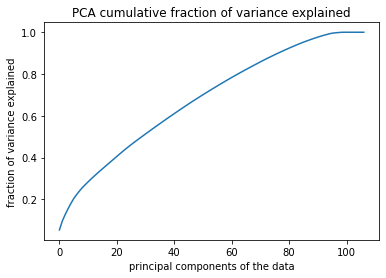

In [95]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


#figure out how much dimension we need after pca
pca = PCA(n_components=X_train.shape[1])
pca_transform = pca.fit_transform(X_train,y_train)
var_values = pca.explained_variance_ratio_


cum_exp_variance = np.cumsum(var_values)
plt.plot(cum_exp_variance)
plt.xlabel('principal components of the data')
plt.ylabel('fraction of variance explained')
plt.title('PCA cumulative fraction of variance explained')

cum_exp_variance

#### Save it as csv 

In [96]:
df.to_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/cleaned.csv')

## Model

In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


## 1. Linear Regression

In [ ]:

lr = LinearRegression()
lr.fit(X_train, y_train)


print('Train R^2', lr.score(X_train,y_train))
print('Val R^2', lr.score(X_val,y_val))

In [ ]:
mean_squared_error(y_train, lr.predict(X_train))

In [ ]:
y_pred_lr = lr.predict(X_val)
mean_squared_error(y_val, y_pred_lr)

## 2. KNN

In [99]:
# Reduce dimension to 2/5/15 with PCA
pca_2 = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=r_state))
pca_15 = make_pipeline(StandardScaler(), PCA(n_components=15, random_state=r_state))
pca_40 = make_pipeline(StandardScaler(), PCA(n_components=40, random_state=r_state))


In [100]:
# Make a list of the methods to be compared
dim_reduction_methods = [('PCA2', pca_2),('PCA15', pca_15),('PCA40', pca_40)]

In [105]:
from sklearn.metrics import mean_squared_error
import time
from sklearn.neighbors import KNeighborsRegressor
n_neighbors=5
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

for i, (name, model) in enumerate(dim_reduction_methods):
    
    #start timer
    time0 = time.time()
    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)
    #time for training
    time1 = time.time()
    
    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)
    mse = mean_squared_error(y_test, knn.predict(model.transform(X_test)))
    #time for test
    time2 = time.time()
    
    print("{}, KNN (k={})\nTest score = {:.2f}".format(name,n_neighbors,acc_knn))
    print('MSE:',mse)
    print('KNN ({}) training time = {}, prediction time ={}\n'.format(name,time1-time0,time2-time1))

PCA2, KNN (k=5)
Test score = 0.18
MSE: 0.4183084201265457
KNN (PCA2) training time = 0.4421577453613281, prediction time =0.10977911949157715

PCA15, KNN (k=5)
Test score = 0.50
MSE: 0.2531915153662074
KNN (PCA15) training time = 0.5450291633605957, prediction time =16.891111850738525

PCA40, KNN (k=5)
Test score = 0.52
MSE: 0.2457889309784781
KNN (PCA40) training time = 0.7535438537597656, prediction time =28.84421396255493



In [107]:
for i in (1,3,5,7,9):
    knn = KNeighborsRegressor(n_neighbors=i)
    #start timer
    time0 = time.time()

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(pca_15.transform(X_train), y_train)
    #time for training
    time1 = time.time()
    
    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(pca_15.transform(X_test), y_test)
    mse = mean_squared_error(y_test, knn.predict(pca_15.transform(X_test)))
    #time for test
    time2 = time.time()
    
    print("{}, KNN (k={})\nTest score = {:.2f}".format('PCA15',i,acc_knn))
    print('MSE:',mse)
    print('KNN (k={}) training time = {}, prediction time ={}\n'.format(i,time1-time0,time2-time1))

PCA15, KNN (k=1)
Test score = 0.19
MSE: 0.4117216918665421
KNN (k=1) training time = 0.1585710048675537, prediction time =10.4082190990448

PCA15, KNN (k=3)
Test score = 0.46
MSE: 0.2765138376601819
KNN (k=3) training time = 0.10442185401916504, prediction time =14.683688879013062

PCA15, KNN (k=5)
Test score = 0.50
MSE: 0.2531915153662074
KNN (k=5) training time = 0.11755180358886719, prediction time =17.025432109832764

PCA15, KNN (k=7)
Test score = 0.52
MSE: 0.24479799616536455
KNN (k=7) training time = 0.1182401180267334, prediction time =18.76262879371643

PCA15, KNN (k=9)
Test score = 0.53
MSE: 0.24065547188645608
KNN (k=9) training time = 0.13667821884155273, prediction time =20.36148190498352



## 3. Random Forest

In [ ]:
rf = RandomForestRegressor(max_depth=5)
rf.fit(X_train, y_train)

print('Train R^2', rf.score(X_train,y_train))
print('Val R^2', rf.score(X_val,y_val))

In [ ]:
mean_squared_error(y_train, rf.predict(X_train))

In [ ]:
y_pred_rf = rf.predict(X_val)
mean_squared_error(y_val, y_pred_rf)

In [ ]:

nn = MLPRegressor(learning_rate_init=0.05)
nn.fit(X_train, y_train)

print('Train R^2', nn.score(X_train,y_train))
print('Val R^2', nn.score(X_val,y_val))

In [ ]:
mean_squared_error(y_train, nn.predict(X_train))


In [ ]:
y_pred_nn = nn.predict(X_val)
mean_squared_error(y_val, y_pred_nn)

## 4. Neural Net

## 5. XGBoost

## 6. LightGBM